# Stack Overflow Developer Survey 2023 Analysis
For this project, I was interestested in using Stack Overflow data from 2023 to better understand:

* Are there significant differences in the popularity of languages between younger and older programming generations?
* Can we use a developers education level and tech stack experience to predict their developer role?
* How significant are Salary differences across Developer Roles?


## Importing Necessary Libraries

In [31]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score,classification_report


## Data Extraction and Loading

In [3]:
# Paths for the datasets
zip_path_2023 = "stack-overflow-developer-survey-2023.zip"
extracted_path_2023 = "stack-overflow-developer-survey-2023"

# Extracting the 2023 zip file and loading the dataset
with zipfile.ZipFile(zip_path_2023, 'r') as zip_ref:
    zip_ref.extractall(extracted_path_2023)

survey_results_2023 = pd.read_csv(os.path.join(extracted_path_2023, "survey_results_public.csv"))
survey_questions_2023 = pd.read_csv(os.path.join(extracted_path_2023, "survey_results_public.csv"))

## Business Understanding


#### What tech stacks have proved most popular in 2023?
We will look at programming languages, frameworks,databases and tools used. We will need to parse string columns with multiple entries



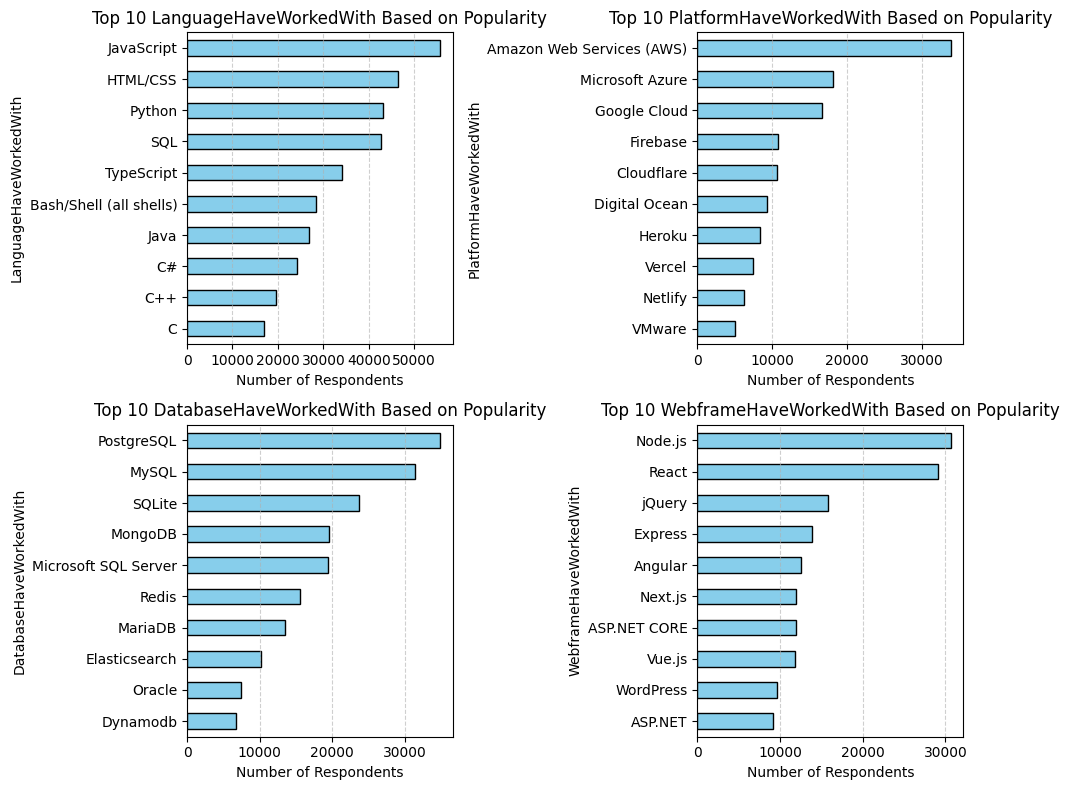

In [27]:
# Visualize top 10 programming languages
def plot_columns_as_subplots(data, column_names):
    num_columns = len(column_names)
    num_rows = (num_columns + 1) // 2
    
    plt.figure(figsize=(10, 8))
    
    for i, column in enumerate(column_names, 1):
        plt.subplot(num_rows, 2, i)
        column_counts = data[column].str.split(';').explode().value_counts().head(10).sort_values()
        column_counts.plot(kind='barh', color='skyblue', edgecolor='black')
        plt.title(f'Top 10 {column} Based on Popularity')
        plt.xlabel('Number of Respondents')
        plt.ylabel(column)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Call the function with the desired column names
column_names = ['LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 'DatabaseHaveWorkedWith', 'WebframeHaveWorkedWith']
plot_columns_as_subplots(survey_results_2023, column_names)


## Data Understanding, Preparation, Modelling & Evaluation

### Question 1: Are there significant differences in the popularity of languages between younger and older programming generations?

#### Data Preparation
We will first bucket Age into younger and older generations to better explore the distinction, if one exists.

In [30]:
# Bucketing by Age
# Create age group buckets
survey_results_2023['AgeBucket'] = np.where(survey_results_2023['Age'].isin(['Under 18 years old', '18-24 years old', '25-34 years old']), 
                                           '35 and under', '35+')
# Segment data by age buckets and calculate programming language popularity
languages_by_bucket = {}
buckets = ['35 and under', '35+']
for bucket in buckets:
    bucket_data = survey_results_2023[survey_results_2023['AgeBucket'] == bucket]
    languages = bucket_data['LanguageHaveWorkedWith'].str.split(';', expand=True).stack()
    languages_by_bucket[bucket] = languages.value_counts()

#### Data Visualisation

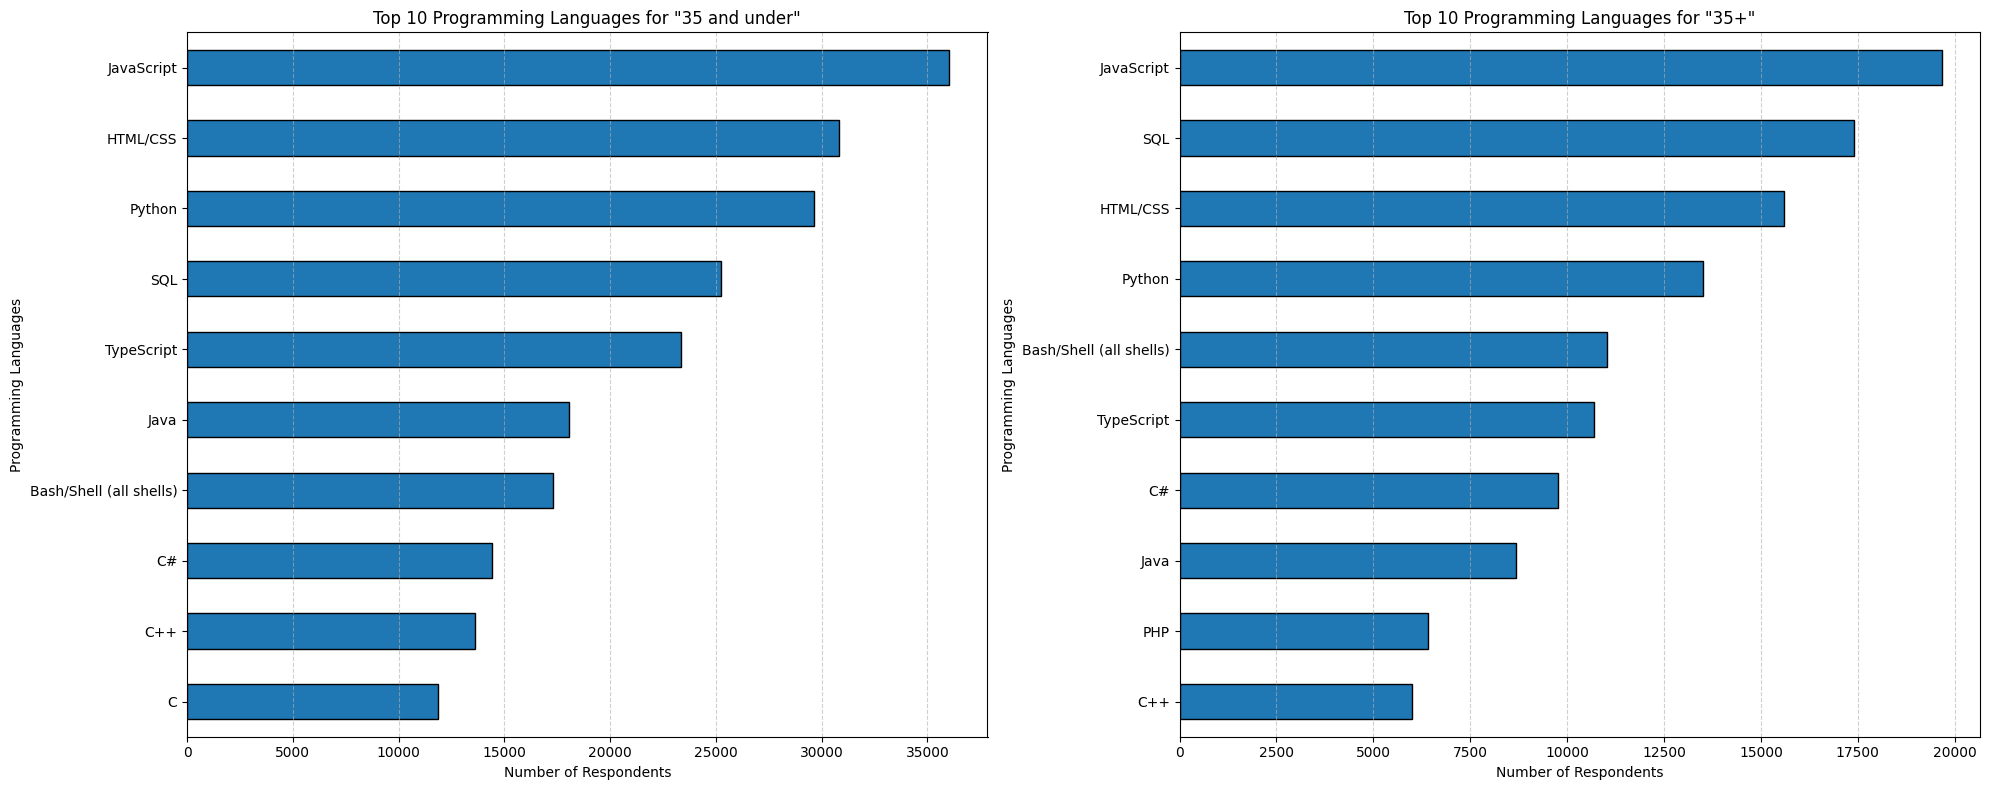

In [6]:
# Visualize programming language popularity for each bucket
plt.figure(figsize=(20, 8))
for idx, bucket in enumerate(buckets,1):
    plt.subplot(1, 2, idx)
    language_counts = languages_by_bucket[bucket].head(10).sort_values()
    # colors = sns.color_palette('Set3', len(language_counts))
    language_counts.plot(kind='barh', edgecolor='black')
    plt.title(f'Top 10 Programming Languages for "{bucket}"')
    plt.xlabel('Number of Respondents')
    plt.ylabel('Programming Languages')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Data Modelling & Evaluation
* We can conclude from the results below that the programming prefrences between these two age groups is statistically significant. 
* A Cramér's V value of 0.35 suggests a moderate association between age groups ("35 and under" and "35+") and programming language preference. 

In [7]:
# 3. Statistical Testing
# Prepare observed frequencies for Chi-Squared test
top_languages = set()
for counts in languages_by_bucket.values():
    top_languages.update(counts.index)
top_languages = list(top_languages)

observed_frequencies_bucket = []
for bucket in buckets:
    row = [languages_by_bucket[bucket].get(language, 0) for language in top_languages]
    observed_frequencies_bucket.append(row)

# print(observed_frequencies_bucket)

# Perform the Chi-Squared test
chi2_bucket, p_value, _, _ = chi2_contingency(observed_frequencies_bucket)

# Calculate Cramér's V
n = survey_results_2023['AgeBucket'].count()
k = len(top_languages)
cramers_v = np.sqrt(chi2_bucket / (n * min(k-1, 2-1)))

print(f'Chi-Squared Statistic: {chi2_bucket}')
print(f'p-value: {p_value}')
print(f'Cramér\'s V: {cramers_v}')

Chi-Squared Statistic: 11062.898432958005
p-value: 0.0
Cramér's V: 0.3522013279311441


### Question 2: Can we use a developers education level and tech stack experience to predict their developer role?

Objective:
The goal of the model is to predict a developer's job role based on certain features from the survey data.

Features:
Programming Languages (LanguageHaveWorkedWith): The programming languages that a respondent has worked with. Each programming language (e.g., Python, JavaScript) is represented as a separate binary column, indicating whether the respondent has worked with that language.

Platforms (PlatformHaveWorkedWith): The platforms or operating systems that a respondent has worked with. Each platform (e.g., Linux, Windows) is represented as a separate binary column, indicating whether the respondent has worked with that platform.

Databases (DatabaseHaveWorkedWith): The databases that a respondent has worked with. Each database (e.g., MySQL, PostgreSQL) is represented as a separate binary column, indicating whether the respondent has worked with that database.

Web Frameworks (WebframeHaveWorkedWith): The web frameworks that a respondent has worked with. Each framework (e.g., React.js, Flask) is represented as a separate binary column, indicating whether the respondent has worked with that framework.

Years of Professional Coding Experience (YearsCodePro): The number of years a respondent has been coding professionally. This provides an indication of their experience level.

Education Level (EdLevel): The highest level of formal education the respondent has completed, such as "Bachelor's degree", "Master's degree", etc. Each education level is represented as a separate binary column.

#### Data Understanding & Preparation
##### Isolate dataset of interest

In [10]:
# Filtering and preparing the data
filtered_data = survey_results_2023.dropna(subset=['DevType'])

# Filter necessary columns
features = ['LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 'DatabaseHaveWorkedWith', 
            'WebframeHaveWorkedWith', 'YearsCodePro', 'EdLevel', 'DevType']
filtered_data = filtered_data[features]

filtered_data.info()
# filtered_data.EdLevel.value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 76872 entries, 1 to 89183
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LanguageHaveWorkedWith  76314 non-null  object
 1   PlatformHaveWorkedWith  57823 non-null  object
 2   DatabaseHaveWorkedWith  65994 non-null  object
 3   WebframeHaveWorkedWith  59738 non-null  object
 4   YearsCodePro            65456 non-null  object
 5   EdLevel                 76872 non-null  object
 6   DevType                 76872 non-null  object
dtypes: object(7)
memory usage: 4.7+ MB


##### Handle missing values and split into test and train

In [13]:

# Transforming YearsCodePro to numerical format for ease of imputation later
filtered_data['YearsCodePro'] = filtered_data['YearsCodePro'].replace({'Less than 1 year': 0.5, 'More than 50 years': 51}).astype(float)

# Splitting the data into training and testing sets
X = filtered_data.drop('DevType', axis=1)
y = filtered_data['DevType']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values AFTER splitting
# cat_imputer = SimpleImputer(strategy='most_frequent')
# X_train['EdLevel'] = cat_imputer.fit_transform(X_train[['EdLevel']])
# X_test['EdLevel'] = cat_imputer.transform(X_test[['EdLevel']])

num_imputer= SimpleImputer(strategy='mean')
X_train['YearsCodePro'] = num_imputer.fit_transform(X_train[['YearsCodePro']])
X_test['YearsCodePro'] = num_imputer.transform(X_test[['YearsCodePro']])

# One-hot encoding for categorical columns
languages_train = X_train['LanguageHaveWorkedWith'].str.get_dummies(sep=';')
languages_test = X_test['LanguageHaveWorkedWith'].str.get_dummies(sep=';')
platforms_train = X_train['PlatformHaveWorkedWith'].str.get_dummies(sep=';')
platforms_test = X_test['PlatformHaveWorkedWith'].str.get_dummies(sep=';')
databases_train = X_train['DatabaseHaveWorkedWith'].str.get_dummies(sep=';')
databases_test = X_test['DatabaseHaveWorkedWith'].str.get_dummies(sep=';')
webframes_train = X_train['WebframeHaveWorkedWith'].str.get_dummies(sep=';')
webframes_test = X_test['WebframeHaveWorkedWith'].str.get_dummies(sep=';')
education_train = pd.get_dummies(X_train['EdLevel'], prefix='Edu')
education_test = pd.get_dummies(X_test['EdLevel'], prefix='Edu')

# Concatenate all features
X_train = pd.concat([X_train['YearsCodePro'], languages_train, platforms_train, databases_train, webframes_train, education_train], axis=1)
X_test = pd.concat([X_test['YearsCodePro'], languages_test, platforms_test, databases_test, webframes_test, education_test], axis=1)

# Scale the numeric feature
scaler = StandardScaler()
X_train['YearsCodePro'] = scaler.fit_transform(X_train[['YearsCodePro']])
X_test['YearsCodePro'] = scaler.transform(X_test[['YearsCodePro']])



#### Train Model & Evaluate Results 

In [15]:
# Initialize and train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions (not executed, just for reference)
y_pred = clf.predict(X_test)

# Evaluating the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=y_test.unique())

# Print accuracy
print(f'Accuracy: {accuracy}')

# Print classification report
print('Classification Report:')
print(classification_rep)

/Users/coduffy/Documents/github/stackoverflow-blog/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.46152845528455283
Classification Report:
                                               precision    recall  f1-score   support

                        Developer, full-stack       0.34      0.30      0.32       260
                  Research & Development role       0.25      0.03      0.05        66
                          Developer, back-end       0.29      0.03      0.05       215
                                      Student       0.25      0.11      0.15       178
                  Developer, game or graphics       0.33      0.29      0.31       304
                               Engineer, data       0.30      0.07      0.11        45
Data scientist or machine learning specialist       0.07      0.02      0.03        57
Developer, desktop or enterprise applications       0.21      0.03      0.06       283
                         Developer, front-end       0.00      0.00      0.00        33
                        Developer, QA or test       0.00      0.00      0.00

/Users/coduffy/Documents/github/stackoverflow-blog/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/coduffy/Documents/github/stackoverflow-blog/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Overall Results & Observations:

* Accuracy: The model has an accuracy of approximately 46.15%. This means that the model correctly predicts the job role about 46.15% of the time on the test data. Given the number of job roles (categories) in this dataset, an accuracy of 46% is considerably better than random guessing, but there is room for improvement. 
* The model performs best (in terms of F1-score) for the "Data or business analyst" role, with an F1-score of 0.64 and a high recall of 0.86. This suggests that the model is particularly good at identifying this role, possibly because it's the most represented role in the dataset (with a support of 5165).
* Several roles like "Data scientist or machine learning specialist", "Developer, front-end", "Developer, QA or test", "Developer Experience", "Blockchain", and others have an F1-score of 0. This indicates that the model struggles to predict these roles. The reasons could be class imbalance, insufficient distinguishing features, or other factors.
* The precision, recall, and F1-score values vary widely across roles. Some roles are predicted with a decent balance of precision and recall (e.g., "Developer, embedded applications or devices"), while others have a notable skew.

##### Recommendations:

* Given the disparity in performance across roles, consider using techniques like oversampling, undersampling, or SMOTE to handle class imbalance.
* It might be beneficial to consider feature engineering or adding additional relevant features that can help distinguish between roles better.

##### What features proved most important?

* The length of time a coder has been developing seems to provide the most signal in predicting their role type

                     Feature  Importance
0               YearsCodePro    0.086929
25                JavaScript    0.019969
22                  HTML/CSS    0.019722
5    Bash/Shell (all shells)    0.019099
48                TypeScript    0.018661
..                       ...         ...
100                  RavenDB    0.000441
17                      Flow    0.000422
40                      Raku    0.000360
1                        APL    0.000324
106                     TiDB    0.000316

[149 rows x 2 columns]


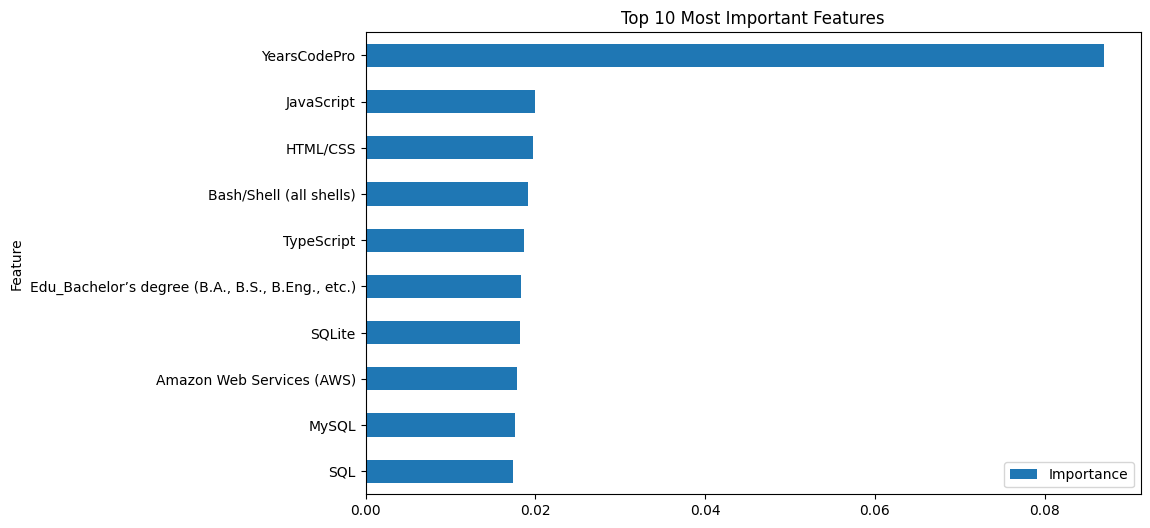

In [ ]:

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
sorted_features = features_df.sort_values(by='Importance', ascending=False)

# Print the sorted features
print(sorted_features)

# Plotting top N features
N = 10  # or any other number you prefer
sorted_features.head(N).plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Top {} Most Important Features'.format(N))
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


### Question 3: How significant are Salary differences across Developer Roles 

#### Data Understanding
Lets first take a look at median salary by country

In [33]:
# Calculate median salary by country
median_salaries_by_country = survey_results_2023[survey_results_2023.ConvertedCompYearly.notnull()].groupby('Country')['ConvertedCompYearly'].median().sort_values(ascending=False).reset_index()
median_salaries_by_country.describe()

,ConvertedCompYearly
count,171.000000
mean,38232.090643
std,30921.113504
min,13.000000
25%,11969.000000
50%,30798.000000
75%,55156.500000
max,150000.000000


#### Data Prepration
Given the disparity of Market salaries across countries we will just take a look at USA survey results 

In [35]:
# Filter data for respondents in the USA

mask = ((survey_results_2023['Country'] == 'United States of America') 
        &(survey_results_2023['Employment'].str.contains('Employed, full time|Independent contractor, freelancer, or self-employed', na=False, regex=True))
       & (~survey_results_2023['DevType'].str.contains('Senior Executive|Student|Engineering manager', na=False, regex=True))
       & survey_results_2023['ConvertedCompYearly'].notnull()
        )


usa_full_time_ic = survey_results_2023[mask]

# Calculate median salary for each developer role
median_salaries = usa_full_time_ic.groupby('DevType')['ConvertedCompYearly'].median().sort_values()


#### Data Visualisation

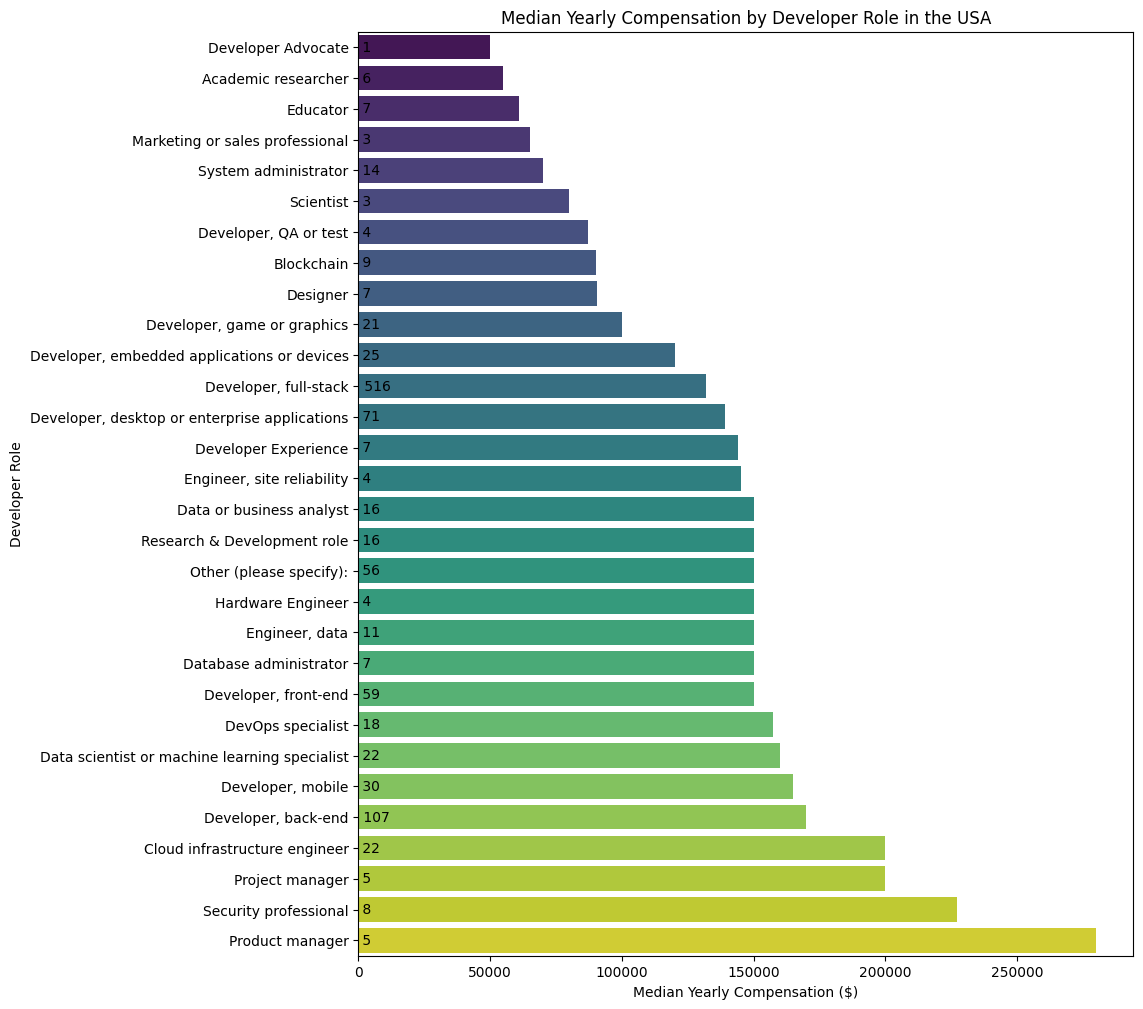

In [36]:
# Calculate count of entries for each DevType
count_entries = usa_full_time_ic['DevType'].value_counts().sort_values()
# Sort count_entries based on the order of developer roles in median_salaries
count_entries = count_entries.reindex(median_salaries.index)

# Plotting the results
plt.figure(figsize=(10, 12))
sns.barplot(y=median_salaries.index, x=median_salaries.values, palette="viridis")
plt.xlabel('Median Yearly Compensation ($)')
plt.ylabel('Developer Role')
plt.title('Median Yearly Compensation by Developer Role in the USA')

# Add count of entries on top of each horizontal column
for i, count in enumerate(count_entries):
    plt.text(count, i, f' {count}', va='center')

plt.show()


#### Data Modelling & Results evaluation
We will conduct a one-way ANOVA test followed by a Tukey pair-wise comparision if the overall results are statistically significant (p=0.05)

In [22]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Handle missing values: Remove rows where either 'DevType' or 'ConvertedCompYearly' is missing
usa_no_null = usa_full_time_ic.loc[:,['DevType', 'ConvertedCompYearly']].dropna(subset=['DevType', 'ConvertedCompYearly'])

groups =(usa_no_null['ConvertedCompYearly'][usa_no_null['DevType'] == dev_type] for dev_type in usa_no_null['DevType'].unique())

# 1. ANOVA Test 
f_value, p_value = stats.f_oneway(*groups)

# Print the results
print(f"F-Value: {f_value}")
print(f"P-Value: {p_value}")

# 2. Post-hoc Analysis (if p_value < 0.05)
if p_value < 0.05:
    tukey_results = pairwise_tukeyhsd(endog=usa_no_null['ConvertedCompYearly'], groups=usa_no_null['DevType'], alpha=0.05)
    print(tukey_results.summary())



F-Value: 3.0217641811703224
P-Value: 1.9266807043446141e-07
                                              Multiple Comparison of Means - Tukey HSD, FWER=0.05                                              
                    group1                                        group2                      meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------------------------------------------------------------------------------------
                          Academic researcher                                    Blockchain   20722.2222    1.0 -206265.2788 247709.7233  False
                          Academic researcher                 Cloud infrastructure engineer  142878.7879 0.6222  -55477.1675 341234.7432  False
                          Academic researcher                      Data or business analyst   85253.8333 0.9996  -120917.803 291425.4697  False
                          Academic researcher Data scientist or machine lear